## Credit scoring problem setup

### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [257]:
# Disable warnings in Anaconda
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [258]:
from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

Let’s write the function that will replace NaN values with the median for each column.

In [259]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

Now, read the data:

In [260]:
# for Jupyter-book, we copy data from GitHub, locally, to save Internet traffic,
# you can specify the data/ folder from the root of your cloned
# https://github.com/Yorko/mlcourse.ai repo, to save Internet traffic
DATA_PATH = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [261]:
data = pd.read_csv(DATA_PATH + "credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the variable types:

In [262]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

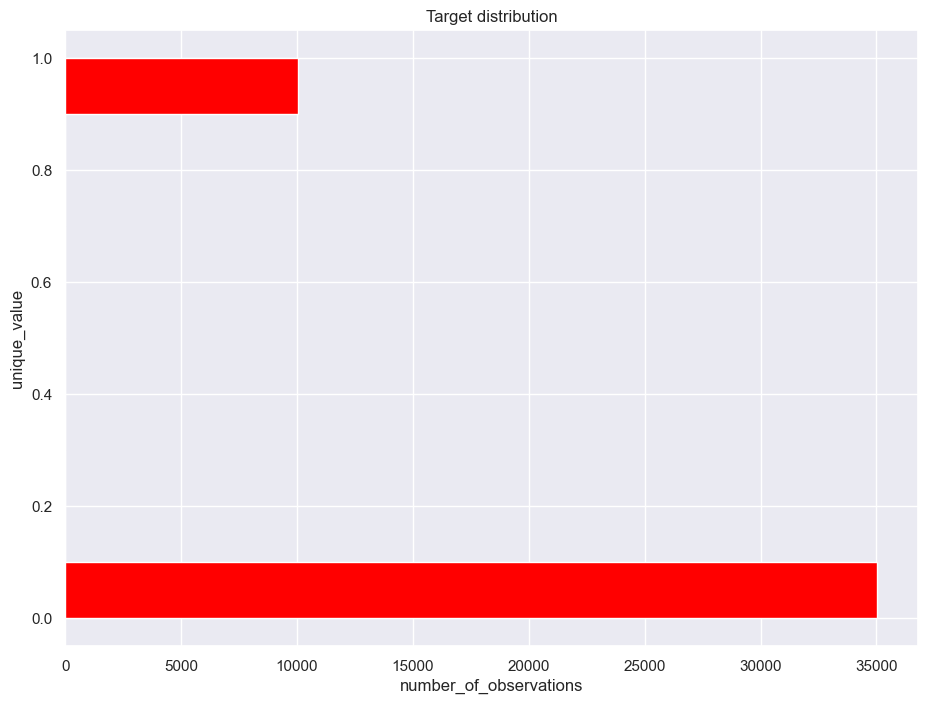

In [263]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

Separate the input variable names by excluding the target:

In [264]:
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace NaN values:

In [265]:
table = fill_nan(data)

Separate the target variable and input features:

In [266]:
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

In [267]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples


def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries


# Save the data about the good and bad customers to split the dataset
good_customers = table.loc[
    table["SeriousDlqin2yrs"] == False, "age"
].values
bad_customers = table.loc[
    table["SeriousDlqin2yrs"] == True, "age"
].values

# Set the seed for reproducibility of the results
np.random.seed(0)

# Generate the samples using bootstrapping and calculate the mean for each of them
good_customer_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(good_customers, 1000)
]
bad_customer_mean_scores = [
    np.mean(sample) for sample in get_bootstrap_samples(bad_customers, 1000)
]

# Print the resulting interval estimates
print(
    "Good customer age: mean interval", stat_intervals(good_customer_mean_scores, 0.1)
)
print(
    "Good customer age: mean interval", stat_intervals(bad_customer_mean_scores, 0.1)
)

Good customer age: mean interval [52.59069983 52.85581385]
Good customer age: mean interval [45.70569021 46.14615001]


## Logistic regression

Let's set up to use logistic regression:

In [268]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a LogisticRegression model and use class_weight='balanced' to make up for our unbalanced classes.

In [269]:
lr = LogisticRegression(random_state=5, class_weight="balanced")

Let’s try to find the best regularization coefficient, which is the coefficient C for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [270]:
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this:

In [271]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal?

In [272]:
grid_search = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc', cv=skf)

In [273]:
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [276]:
y_pr=grid_search.decision_function(X)
np.mean(y_pr)

0.1784906617003459

In [277]:
ROC_AUC_best_model_lr = grid_search.best_score_
print("ROC_AUC_best_model_lr =", ROC_AUC_best_model_lr)

ROC_AUC_best_model_lr = 0.8089120626797153


In [278]:
print(grid_search.best_params_)

{'C': 0.001}


**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

In [279]:
standard_deviation_on_validation_percents = grid_search.cv_results_["std_test_score"][1]*100
print("Standard deviation on validation percents is", standard_deviation_on_validation_percents)

Standard deviation on validation percents is 0.8137559189742445


## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

In [280]:
from sklearn import preprocessing

standart_scaler = preprocessing.StandardScaler()
np_scaled = standart_scaler.fit_transform(X)
X_normalized = pd.DataFrame(np_scaled, columns=independent_columns_names)
X_normalized.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0.872891,-0.121432,-0.142577,-0.092452,-0.082208,0.171676,-0.685453
1,0.463373,-0.121432,1.425692,-0.092452,-0.082208,-0.091407,-0.685453
2,-0.696928,-0.121432,-0.142493,-0.092452,-0.082208,0.040486,-0.685453
3,-0.560422,-0.121432,-0.142678,-0.092452,-0.082208,0.377605,1.094817
4,-0.150904,-0.121432,-0.142568,-0.092452,-0.082208,-0.510476,-0.685453


In [281]:
%%time

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr.fit(X_normalized, y)

CPU times: total: 62.5 ms
Wall time: 55.2 ms


LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [282]:
coefficients_lr = lr.coef_[0]
feature_names_lr = list(X)

lr_coef_df = pd.DataFrame(
    {'coefficients': coefficients_lr,
     'feature_names': feature_names_lr,
    })

In [283]:
sorted_lr_coef_df = lr_coef_df.sort_values(by=['coefficients'], ascending=False)
display(sorted_lr_coef_df)

,coefficients,feature_names
1,0.723427,NumberOfTime30-59DaysPastDueNotWorse
3,0.516788,NumberOfTimes90DaysLate
4,0.193558,NumberOfTime60-89DaysPastDueNotWorse
6,0.101443,NumberOfDependents
2,-0.024096,DebtRatio
5,-0.163146,MonthlyIncome
0,-0.416702,age


**Question 6.** Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

To calculate how much a feature affects the Logistic Regression prediction using the softmax function, you can use the coefficient value ('w') associated with that feature. 

The softmax function is typically used in multiclass classification problems. In this case, the output of the Logistic Regression model gives a probability distribution over the different classes. Each class has its own set of coefficients.

Here are the steps to calculate how much a feature affects the Logistic Regression prediction:

1. Train the Logistic Regression model using your dataset.
2. Obtain the coefficient values ('w') of the feature you are interested in. These values will be one for each class. If it is a binary classification problem, there will be only one coefficient value for the feature.
3. Calculate the exponential of the coefficients:
   exp_w = exp(w)
4. Sum up the exponential of all the coefficient values for that feature, across all classes:
   sum_exp_w = sum(exp_w)
5. Calculate the importance/impact of the feature by dividing each exponential coefficient value by the sum of all exponentials:
   importance_feature = exp_w / sum_exp_w

This will give you a measure of how much the feature affects the Logistic Regression prediction using the softmax function. The higher the value of importance_feature, the more influential the feature is for the corresponding class prediction.

In [284]:
debt_ratio_coef = lr.coef_[0][2]
print(f'Debt Ratio feature coefficient is {debt_ratio_coef}')

Debt Ratio feature coefficient is -0.02409605224751049


In [285]:
exp_debt_ratio_coef = np.exp(debt_ratio_coef)
print(f'Exponent of Debt Ratio feature coefficient is {exp_debt_ratio_coef}')

Exponent of Debt Ratio feature coefficient is 0.9761919398247532


In [286]:
sum_of_all_exp_coefs = np.sum(np.exp(lr.coef_[0]))
print(f'Sum of exponents of all features coefficient is {sum_of_all_exp_coefs}')

Sum of exponents of all features coefficient is 8.543321181403357


In [287]:
print(f'Sigma is {exp_DebtRatio_feat_coef / sum_of_all_feat_coefs}')

Sigma is 0.1121982527781209


**Question 7.** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

In [289]:
X_added_20_years = X.copy()
X_added_20_years['age'] += 20
X_added_20_years.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,84,0,0.249908,0,0,8158.0,0.0
1,78,0,3870.000000,0,0,5166.0,0.0
2,61,0,0.456127,0,0,6666.0,0.0
3,63,0,0.000190,0,0,10500.0,2.0
4,69,0,0.271820,0,0,400.0,0.0


In [290]:
%%time

lr = LogisticRegression(C=0.001, random_state=5, class_weight="balanced")
lr.fit(X_added_20_years, y)

CPU times: total: 281 ms
Wall time: 210 ms


LogisticRegression(C=0.001, class_weight='balanced', random_state=5)

In [291]:
coefficients_lr = lr.coef_[0]
feature_names_lr = list(X)

lr_coef_df = pd.DataFrame(
    {'coefficients': coefficients_lr,
     'feature_names': feature_names_lr,
    })

In [219]:
sorted_lr_coef_df = lr_coef_df.sort_values(by=['coefficients'], ascending=False)
display(sorted_lr_coef_df)

,coefficients,feature_names
1,0.443701,NumberOfTime30-59DaysPastDueNotWorse
3,0.391997,NumberOfTimes90DaysLate
4,0.232903,NumberOfTime60-89DaysPastDueNotWorse
6,0.188607,NumberOfDependents
2,-0.000010,DebtRatio
5,-0.000013,MonthlyIncome
0,-0.009033,age


In [292]:
grid_search = GridSearchCV(lr, param_grid=parameters, scoring='roc_auc', cv=skf)
grid_search.fit(X_added_20_years, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(C=0.001, class_weight='balanced',
                                          random_state=5),
             param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [293]:
y_pr=grid_search.decision_function(X_added_20_years)
np.mean(y_pr)

0.2280405866999035

## Random Forest

Import the Random Forest classifier:


In [294]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [295]:
rf = RandomForestClassifier(
    n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced"
)

We will search for the best parameters among the following values:

In [296]:
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation? Select the closest answer.

In [249]:
%%time

grid_search_rf = GridSearchCV(rf, param_grid=parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
rf_grid_search = grid_search_rf.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
CPU times: total: 7.08 s
Wall time: 5min 39s


In [250]:
ROC_AUC_best_model_rf = rf_grid_search.best_score_

In [251]:
print("ROC_AUC_best_model_difference =", ROC_AUC_best_model_rf - ROC_AUC_best_model_lr)

ROC_AUC_best_model_difference = 0.026866482423537952


**Question 9.** What feature has the weakest impact in the Random Forest model?

In [252]:
coefficients_rf_cv = abs(grid_search.best_estimator_.coef_[0])
feature_names_rf_cv = list(X)

rf_cv_coef_df = pd.DataFrame(
    {'coefficients': coefficients_rf_cv,
     'feature_names': feature_names_rf_cv,
    })

In [253]:
sorted_rf_cv_coef_df = rf_cv_coef_df.sort_values(by=['coefficients'], ascending=False)
display(sorted_rf_cv_coef_df)

,coefficients,feature_names
1,0.473990,NumberOfTime30-59DaysPastDueNotWorse
3,0.416527,NumberOfTimes90DaysLate
4,0.239324,NumberOfTime60-89DaysPastDueNotWorse
6,0.160753,NumberOfDependents
0,0.014272,age
5,0.000008,MonthlyIncome
2,0.000006,DebtRatio


**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

Spent less time for model fitting

## Bagging

Import modules and set up the parameters for bagging:

In [43]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

In [45]:
%%time

bg = BaggingClassifier(LogisticRegression(class_weight="balanced"),n_estimators=100,n_jobs=-1,random_state=42)
clf = RandomizedSearchCV(estimator=bg, param_distributions=parameters, n_iter=20, n_jobs=-1, scoring="roc_auc", cv=skf, random_state=1)
search = clf.fit(X, y)

CPU times: total: 11.8 s
Wall time: 2h 2min 43s


In [47]:
search.best_params_

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}

In [48]:
search.best_score_

0.8087377446777644

**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

Less correlation between single models